# Viscous length scale estimation

$$
    \delta_\nu \equiv \left( \frac{\mathrm{Pr}}{\mathrm{Ra}} \right)^{1/4}
        \left| \left. \frac{\partial \langle u \rangle}{\partial z} \right|_{z=0} \right|^{-1/2}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import tools


In [2]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/07_appendix/'
data_path = base_path + 'final_data/viscous_lengthscale/'
config_file = base_path + 'config/viscous_lengthscale.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)
rayleigh = config['parameters']['rayleigh']
prandtl = config['parameters']['prandtl']


In [3]:
data = xr.open_mfdataset(data_path + '*.nc')
u_data = data.u.isel(t=((55. <= data.t) & (data.t <= 65.)))
u_data = tools.insert_bc(u_data, bottom=0., top=0.).chunk({'z': -1, 'x': -1})
u_data = u_data.mean('t')


In [4]:
du_dz = np.abs(u_data.differentiate('z', edge_order=2))
delta_bot = ((prandtl/rayleigh)**(1/4)*du_dz.sel(z=0.)**(-1/2)).compute()
delta_top = ((prandtl/rayleigh)**(1/4)*du_dz.sel(z=1.)**(-1/2)).compute()
delta_mean = (delta_bot.mean('x') + delta_top.mean('x'))/2


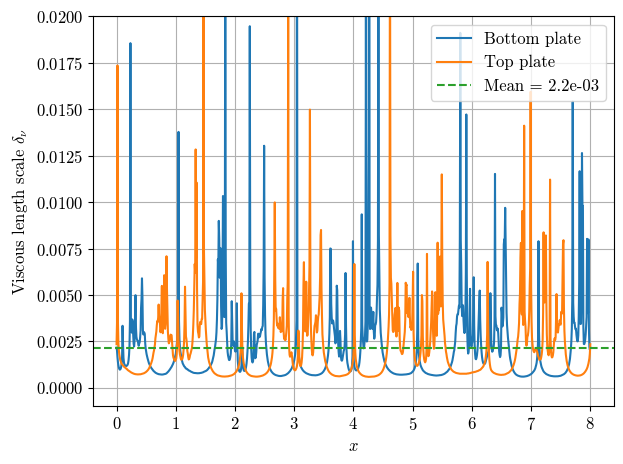

In [14]:
fig, ax = plt.subplots()
ax.plot(delta_bot.x, delta_bot, label='Bottom plate')
ax.plot(delta_top.x, delta_top, label='Top plate')
ax.axhline(
    delta_mean, color='tab:green', linestyle='--',
    label=f'Mean = {delta_mean:.1e}',
)
ax.set(
    xlabel='$x$', ylabel='Viscous length scale $\\delta_\\nu$',
    ylim=(-1e-3, 0.02),
)
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
fig.savefig(fig_path + 'delta_nu.pdf')
